### Randomly sample MAX_SAMPLE_SIZE CFGs whose size < MAX_GRAPH_SIZE

In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import glob
import os
import random
import pickle as pkl
import numpy as np
import scipy as sp
import pandas as pd
from networkx import number_of_nodes, adjacency_matrix
from node_attributes import node_features


class_dirnames = glob.glob('*')

small_graph_filenames = []
total = 0
MAX_SAMPLE_SIZE = 140
MAX_GRAPH_SIZE = 480
output_dir = 'Small%dACFGs/' % MAX_GRAPH_SIZE
CFG_labels = ['Benign', 'Bagle', 'Bifrose']
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [15]:
"""Path name format: class/graph_id/pkl_name"""
for class_dirname in class_dirnames:
    if class_dirname not in CFG_labels:
        continue
    
    print("Processing %s CFGs" % class_dirname)
    data_dirnames = glob.glob(class_dirname + '/*')
    random.shuffle(data_dirnames)

    cnt = MAX_SAMPLE_SIZE
    for data_dirname in data_dirnames:
        pkl_filenames = glob.glob(data_dirname + '/*')
        if len(pkl_filenames) == 0:
            print('[Warning] %s is empty' % data_dirname)
        else:  # Assume only 1 file under data dir
            total += 1
            G = pkl.load(open(pkl_filenames[0], 'rb'))
            if number_of_nodes(G) < MAX_GRAPH_SIZE:
                cnt -= 1
                if cnt == 0:  # Exceed sample size
                    break
                
                graph_id = pkl_filenames[0].split('/')[1]
                label = class_dirname
                small_graph_filenames.append(pkl_filenames[0])
                features = node_features(G)
                np.savetxt(output_dir + graph_id + '.features.txt', features, fmt="%d")
                np.savetxt(output_dir + graph_id + '.label.txt', np.array([label]), fmt="%s")
                np.savetxt(output_dir + graph_id + '.adjacent.txt', adjacency_matrix(G).todense(), fmt="%d")
                sp.sparse.save_npz(output_dir + graph_id + '.adjacent', adjacency_matrix(G))


np.savetxt(output_dir + 'small_graph_filenames.csv', small_graph_filenames, fmt="%s")
small_cnt = len(small_graph_filenames)
print("%d / %d = %.2f" % (small_cnt, total, small_cnt / total))
print("10 random files processed")
print([small_graph_filenames[x] for x in np.random.randint(0, small_cnt, size=10)])

Processing Bagle CFGs
Processing Bifrose CFGs
Processing Benign CFGs
[Warning] Benign/ef11db385af16b633efbd524907baa58 is empty
410 / 820 = 0.50
10 random files processed
['Benign/566c93b64e5709e5058d4aa1a711663c/566c93b64e5709e5058d4aa1a711663c.gpickle', 'Benign/f499d581cfc29baa3a12e07bce0dd877/f499d581cfc29baa3a12e07bce0dd877.gpickle', 'Bifrose/555b225fb25cfe1787273152ea5aa8ff/ar4up-ce0dd0258a.gpickle', 'Bagle/3dd4f928f077ed4eeea9d396f748b952/Trojan-Downloader.Win32.Bagle.ai.gpickle', 'Bifrose/07eef747f3b1b183ea17323789026e4e/Backdoor.Win32.Bifrose.alab.gpickle', 'Benign/24f260a978004a0cdaedce8f7fc67c86/24f260a978004a0cdaedce8f7fc67c86.gpickle', 'Bifrose/4bfaaf77df7bf02c19564305cb012ba0/Backdoor.Win32.Bifrose.afnb.gpickle', 'Bifrose/25817effc1a07bd9cb763c95baa401e1/Backdoor.Win32.Bifrose.dh.gpickle', 'Bifrose/44eb75dac7c52f5d8bc338ed36a070d5/Backdoor.Win32.Bifrose.aivh.gpickle', 'Bifrose/44eb75dac7c52f5d8bc338ed36a070d5/Backdoor.Win32.Bifrose.aivh.gpickle']


Counter({'Bifrose': 139, 'Bagle': 139, 'Benign': 132})


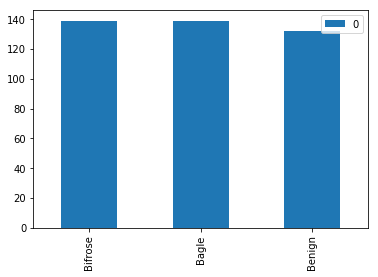

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

data = pd.read_csv(output_dir + 'small_graph_filenames.csv',
                   delimiter='/', names=['label', 'graph_id', 'filename'])
label_cnts = Counter(data['label'])
print(label_cnts)
df = pd.DataFrame.from_dict(label_cnts, orient='index')
df.plot(kind='bar')